In [1]:
import torch
from torch import optim
import numpy as np
import matplotlib.pyplot as plt
from datasets.custom_datasets import LSPDataset, MPIIDataset
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from models.pose_estimation_model import TransformerPoseModel
from utils.training_helpers import resize_single_joint
from utils.training_helpers import plot_with_joints
from utils.preprocessing_helpers import get_image_sizes
from models.loss import JointsMSELoss
from torch.optim import Adam
from utils.heatmap_funcs import generate_gaussian_heatmap, upsample_heatmap


In [2]:
# dataset loading
#swap axis -> (n,#joints,cooridantes)
annot = np.load('/home/mxerri/JointPoseEstimation/Data/lsp/leeds_sports_extended.npy')
annot_s = np.swapaxes(annot, 0,2)
annot_s = np.swapaxes(annot_s,1,2)

# retrieve image sizes
image_sizes = get_image_sizes('/home/mxerri/JointPoseEstimation/Data/lsp/images/')
image_sizes_resized = get_image_sizes('/home/mxerri/JointPoseEstimation/Data/lsp/images224/')
annot_resize = np.zeros_like(annot_s)

# resize annotations
for i in range(10000):
    annot_resize[i] = resize_single_joint(annot_s[i],image_sizes_resized[i],image_sizes[i] ) 
    # make annortations into 56 x 56 for loss function 
    annot_resize[i] = resize_single_joint(annot_resize[i],(56,56),(224,224))

print(annot_resize.shape)

# heatmap annotations are converted in the dataloader, otherwise we can change pagetable size 
# to accomodate a larger array to pre-load 

# create officia datasets and dataloaders for training
dataset = LSPDataset(annot_resize,"/home/mxerri/JointPoseEstimation/Data/lsp/images224/")
dataset_mini = torch.utils.data.Subset(dataset,list(range(0,20)))
train_loader = DataLoader(dataset, batch_size=32, shuffle=False)
train_loader_mini = DataLoader(dataset_mini, batch_size=5, shuffle=False)

(10000, 14, 3)


(10, 14, 56, 56)
(18, 40)
[18. 40.  1.]


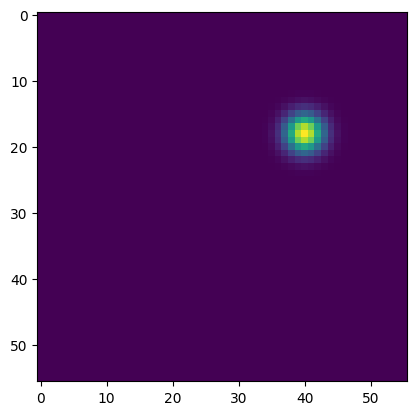

In [3]:
# convert to joint heatmaps from coordiantes: 
heatmaps = generate_gaussian_heatmap(annot_resize[0:10],(56,56),2)
print(heatmaps.shape)
# heatmaps_down = upsample_heatmap(heatmaps, (56,56))
plt.imshow(heatmaps[0][2])
z = np.unravel_index(heatmaps[0,2,:,:].argmax(), heatmaps[0,2,:,:].shape)
print(z)
print(annot_resize[0,2,:])



In [4]:
model = TransformerPoseModel(2)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = JointsMSELoss()

/home/mxerri/.local/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [5]:
for epoch in range(3):
    total_loss = 0
    count = 0
    for batch_idx, (imgs, labels) in enumerate(train_loader):

        #print(batch_idx)
        #print(imgs.shape)
        #print(labels.shape)

        optimizer.zero_grad()

        output = model(imgs) # -> (5, H/4, W/4, #joints) 

        # Heatmap dimensions are 56x56, so we need to resize at the end

        #print("model output shape")
        #print(output.shape)

        # upsample heatmap to 224 
        #output = upsample_heatmap(output, (224,224)) # check this doesnt mess w back prop

        loss = loss_func(output, labels.float())
        
        loss.backward()
        optimizer.step()
        total_loss += loss

        print("batch completed")
    if epoch % 1 == 0:
        print("epoch: ", epoch, "loss: ", total_loss)




Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/mxerri/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_23270/254056181.py", line 24, in <module>
    loss.backward()
  File "/home/mxerri/.local/lib/python3.8/site-packages/torch/_tensor.py", line 492, in backward
    torch.autograd.backward(
  File "/home/mxerri/.local/lib/python3.8/site-packages/torch/autograd/__init__.py", line 251, in backward
    Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/mxerri/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2105, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "/home/mxerri/.local/lib/python3.8/site-packages/IPython/core/ultratb.py", line 